This work builds on top of Jeremy Howard's amazing kernel "Some DICOM gotchas to be aware of (fastai)". In that kernel, Jeremy notices some range of pixel values are WAY out of what we can usually expect in terms of Hounsfield Units. We could decide to discard those scans entirely, but some similar value appear in the test set as well, and (as we'll see) for good reason. I decided to investigate those in depth, to understand what was going on.

Note: this is the first time in three or four competitions that I dare publish a kernel (because usually I never have anything new to offer). So please forgive me if the following is total nonsense, or something that everybody knew and thought was obvious. We'll start by importing the needed stuff.

In [ ]:
!pip install torch torchvision feather-format pyarrow --upgrade   > /dev/null
!pip install git+https://github.com/arraiyopensource/kornia       > /dev/null
!pip install git+https://github.com/fastai/fastai_dev             > /dev/null

    
from fastai2.basics           import *
from fastai2.medical.imaging  import *
from tqdm import tqdm_notebook
np.set_printoptions(linewidth=120)

In [ ]:
path_inp = Path('../input')
path = path_inp/'rsna-intracranial-hemorrhage-detection'
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

# HounsField Units: 50 shades of gray

From what I've gathered so far, Hounsfield Units of body parts don't seem to be supposed to go under a thousand or above three thousand. See: http://www.startradiology.com/the-basics/x-rayct-technique/

<img src='https://i.pinimg.com/originals/88/cc/4e/88cc4ed3b0451aa5bbfad74b0d28aecb.jpg'>

<img src='https://pocketdentistry.com/wp-content/uploads/285/F000146f014-005-9780323096331.jpg'>

Yet, using Jeremy's kernel, we encounter value that go as high as +/- 30000 !

In [ ]:
# To understand what's going on here, please refer to https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai
path_df = path_inp/'creating-a-metadata-dataframe'

df_lbls = pd.read_feather(path_df/'labels.fth')
df_tst = pd.read_feather(path_df/'df_tst.fth')
df_trn = pd.read_feather(path_df/'df_trn.fth')

comb = df_trn.join(df_lbls.set_index('ID'), 'SOPInstanceUID')
assert not len(comb[comb['any'].isna()])

# This is where you find the weird min/max values
repr_flds = ['BitsStored','PixelRepresentation']
comb.pivot_table(values=['img_mean','img_max','img_min','PatientID','any'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count','any':'mean'})

In [ ]:
# we've got 256 images in the training set with such high values
comb[comb['img_max'] > 30000].shape

In [ ]:
#as seen two cells above, we've got at least an image with a max px value of 32767
max_val = comb['img_max'].max() #32767
#Actually, we've got two of them
comb[comb['img_max'] == max_val]['fname']

In [ ]:
# We can use fastaiv2 fantastic functionalities to quickly plot this pic
dcmread('../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_d6a09aba5.dcm').show(figsize=(6,6))

Holy cow. This guy's scan is really shiny ! This is obvisouly a metal (golden ?) tooth screwing up the scan here. It's also consistent with the values found in the [wikipedia page for hounsfield units](https://en.wikipedia.org/wiki/Hounsfield_scale#cite_note-BolligerOesterhelweg2009-22): 

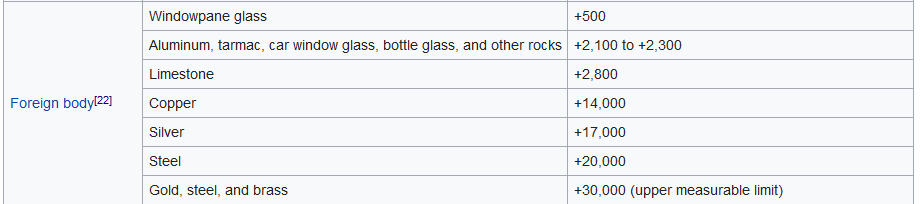

This why I said at the beginning of this kernel that we couldn't discard these pics. We don't want our models to be completely lost when they encounter this type of situation in the wild, because a guy deserves the same quality of health care no matter if he's an "edge case" for a model because of his/her dentition or not. This is the kind of situation where I suppose a Hippocrates Serment for data scientist would start to make sense. 

But I digress... The following cell will let you plot random picture with those high pixel values, so that you can get a sense of what's going on.


In [ ]:
# floor_value is the value above which we consider pixel values to be curious (the cases we want to investigate)
# based on the above table, I put it at 3000, but feel free to experiment
floor_value = 3000
f_name = comb[comb['img_max'] > floor_value].sample()['fname'].values[0]
print(f_name)
dcmread(f_name).show(figsize=(6,6))

If you shift enter the above cell several times, you'll see a lot of shiny items like in the first example. This poses a problem because it affets pixels values that are even far away from it (because of the shiny rays that emanates from them). If you want to see an incredible example of this, look at this one:

In [ ]:
dcmread('../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_b914af0ba.dcm').show(figsize=(6,6))

As such, I have no clue how to handle those. Should we "ceil" the pixels with torch.clamp_max ? I though offering this kernel would start the discussion.

As this is my very first public Kernel, I'll be grateful for any idea/tip to improve it (i.e, what you'd like me to investigate next

In [ ]:
# PS: not all of them are shiny objects. Some other are just plainly screwed images, like this one: 
dcmread('../input/rsna-intracranial-hemorrhage-detection/stage_1_train_images/ID_b79eed528.dcm').show(figsize=(6,6))
# I wonder how we could come up with a systematized way to find them out ? I'll keep looking and update this kernel if I come up with something interesting.
# In the meantime, thank you for you attention !


#### Edit: # So I've been trying to find other pictures that were damaged like the one above. I don't think there are any, but I found interesting stuff in the process. You'll find the results in [this kernel](http://https://www.kaggle.com/bdubreu/finding-screwed-images-some-data-statistics?scriptVersionId=22054845)